In [63]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [65]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


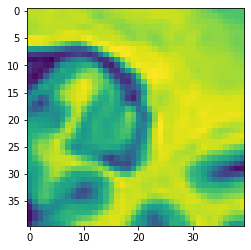

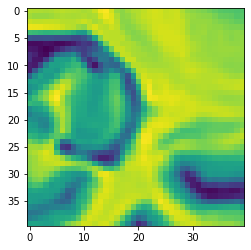

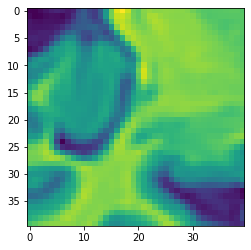

In [110]:
def sagital_adjacent_slices(img_n_mmni, m, epsilon, y_tuple, z_tuple):
    crop_img = img_n_mmni.slicer[m-epsilon:m+epsilon+1:epsilon, y_tuple[0]:y_tuple[1], z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (1, 2, 0))
    return crop_img

def coronal_adjacent_slices(img_n_mmni, x_tuple, m, epsilon, z_tuple):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], m-epsilon:m+epsilon+1:epsilon, z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (0, 2, 1))
    return crop_img

def axial_adjacent_slices(img_n_mmni, x_tuple, y_tuple, m, epsilon):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], y_tuple[0]:y_tuple[1], m-epsilon:m+epsilon+1:epsilon]
    return crop_img.get_fdata()

#Test of coronal projection
img_data = coronal_adjacent_slices(img_n_mmni, (40,80), 110, 5,(40,80))
#img_data = coronal_adjacent_slices(img_n_mmni, (0,181), 110, 5,(0,181))
img_data = coronal_adjacent_slices(img_n_mmni, (100,140), 110, 5,(40,80))


for i in range(3):
    plt.imshow(img_data[:, :, i])
    plt.show()

In [67]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head(7)


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [105]:
print(y_data.shape)

(420, 2)


In [68]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
        
            
            for i in range(-3,3):
                img_3_projections = []
                img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
            
            
            for i in range(-3,3):
                img_3_projections = []

                img_slices_data = sagital_adjacent_slices(img_n_mmni, 120+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_slices_data = img_slices_data[:, :, ::-1]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (100+i,140+i), 110+i, epsilon, (30+i,70+i))
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni,(100+i,140+i), (90+i,130+i), 60+i, epsilon)
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
        
    X_data = np.array(X_data)   
    return X_data, Y_data


In [69]:
X_data, Y_data = Data_preparation(y_data, 1) #epsilon=2
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(5028, 3, 40, 40, 3)
5028


In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=49) 

print("len(X_train) = ", len(X_train))
print("len(X_test) = ", len(X_test))

len(X_train) =  4022
len(X_test) =  1006


(420, 2)


ValueError: Could not interpret input 'Group'

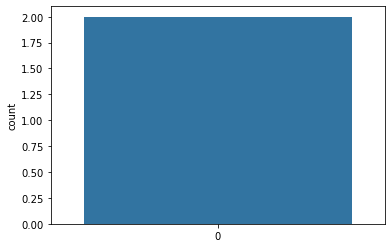

In [104]:
map_characters = {0: 'CN', 1: 'AD'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
print(y_data.shape)
df['labels'] = Y_train[0]
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
sns.countplot(x ='Group', data = df)

In [71]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def Slices_network(inputs, i, padding='same'):
    x = inputs[:,i,:,:]
    num_filters = 32

    x = SeparableConv2D(filters=num_filters, kernel_size=(4,4), strides=1, padding=padding)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    
    num_filters *= 2
    x = SeparableConv2D(filters=num_filters, kernel_size=(2,2), strides=1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(Slices_network(inputs=inputs, i=i, padding='same'))

    x = Concatenate(name = "Concat1")(out_list)
    x = Flatten(name = "Flatten1")(x)
    
    outputs = Dense(nb_class, activation='softmax')(x)
    
    return Model(inputs, outputs)

    
model = create_model_2D_epsilon(X_train[0].shape)
model.summary()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
     

    

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_9 (Sl  (None, 40, 40, 3)   0           ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_10 (S  (None, 40, 40, 3)   0           ['input_4[0][0]']                
 licingOpLambda)                                                                            

In [72]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), callbacks=[callback])

2022-12-11 15:21:10.179036: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 231667200 exceeds 10% of free system memory.


Epoch 1/50
126/126 [==============================] - 35s 231ms/step - loss: 0.5911 - accuracy: 0.7203 - val_loss: 0.6162 - val_accuracy: 0.7425
Epoch 2/50
126/126 [==============================] - 25s 200ms/step - loss: 0.4820 - accuracy: 0.7974 - val_loss: 0.5246 - val_accuracy: 0.7475
Epoch 3/50
126/126 [==============================] - 25s 202ms/step - loss: 0.4405 - accuracy: 0.8138 - val_loss: 0.4721 - val_accuracy: 0.7903
Epoch 4/50
126/126 [==============================] - 25s 201ms/step - loss: 0.4007 - accuracy: 0.8342 - val_loss: 0.4471 - val_accuracy: 0.8082
Epoch 5/50
126/126 [==============================] - 25s 200ms/step - loss: 0.3820 - accuracy: 0.8424 - val_loss: 0.4407 - val_accuracy: 0.8131
Epoch 6/50
126/126 [==============================] - 25s 201ms/step - loss: 0.3674 - accuracy: 0.8558 - val_loss: 0.4054 - val_accuracy: 0.8201
Epoch 7/50
126/126 [==============================] - 25s 202ms/step - loss: 0.3420 - accuracy: 0.8647 - val_loss: 0.3847 - val_ac

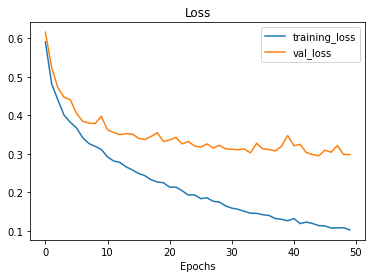

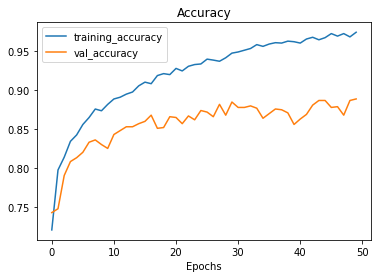

In [73]:
def plot_loss_curves(history):
      
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      accuracy = history.history['accuracy']
      val_accuracy = history.history['val_accuracy']

      epochs = range(len(history.history['loss']))

      # Plot loss
      plt.plot(epochs, loss, label='training_loss')
      plt.plot(epochs, val_loss, label='val_loss')
      plt.title('Loss')
      plt.xlabel('Epochs')
      plt.legend()

      # Plot accuracy
      plt.figure()
      plt.plot(epochs, accuracy, label='training_accuracy')
      plt.plot(epochs, val_accuracy, label='val_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()

plot_loss_curves(history)

32/32 [==============================] - 2s 62ms/step
[[507  46]
 [ 66 387]]


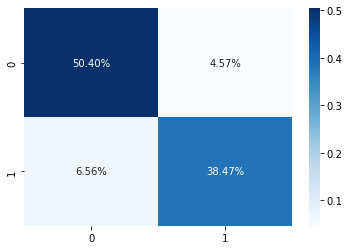

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

labels = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(labels, pred)
print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()


## Training with whole AD and CN data for MCI 


In [124]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def Slices_network(inputs, i, padding='same'):
    x = inputs[:,i,:,:]
    num_filters = 32
    print(x.shape)
    x = SeparableConv2D(filters=num_filters, kernel_size=(4,4), strides=1, padding=padding)(x)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    print(x.shape)
    x = Activation('relu')(x)
    
    num_filters *= 2
    print(x.shape)
    x = SeparableConv2D(filters=num_filters, kernel_size=(2,2), strides=1)(x)
    print(x.shape)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    print(x.shape)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    print(x.shape)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(Slices_network(inputs=inputs, i=i, padding='same'))

    print("iiiii")
    x = Concatenate(name = "Concat1")(out_list)
    print(x.shape)
    x = Flatten(name = "Flatten1")(x)
    print(x.shape)
    outputs = Dense(nb_class, activation='softmax')(x)
    print(outputs.shape)
    return Model(inputs, outputs)

    
model2 = create_model_2D_epsilon(X_train[0].shape)
model2.summary()
model2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
     

(None, 40, 40, 3)
(None, 37, 37, 32)
(None, 37, 37, 32)
(None, 18, 18, 32)
(None, 18, 18, 32)
(None, 17, 17, 64)
(None, 9, 9, 64)
(None, 5184)
(None, 40, 40, 3)
(None, 37, 37, 32)
(None, 37, 37, 32)
(None, 18, 18, 32)
(None, 18, 18, 32)
(None, 17, 17, 64)
(None, 9, 9, 64)
(None, 5184)
(None, 40, 40, 3)
(None, 37, 37, 32)
(None, 37, 37, 32)
(None, 18, 18, 32)
(None, 18, 18, 32)
(None, 17, 17, 64)
(None, 9, 9, 64)
(None, 5184)
iiiii
(None, 15552)
(None, 15552)
(None, 2)
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operator

In [76]:
#history2 = model2.fit(X_data, Y_data, epochs=30)

In [77]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data

In [122]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data_MCI = get_data_MCI(path)
y_data_MCI.head()
print(y_data_MCI.shape)

(300, 3)


In [79]:
from tensorflow.keras.utils import to_categorical


def Data_preparation_MCI(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
        
            
            for i in range(-3,3):
                img_3_projections = []
                img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                    Y_data.append(1)
                elif Y['Conversion'][index] == 4 : #sMCI
                    Y_data.append(0)    

            
            for i in range(-3,3):
                img_3_projections = []

                img_slices_data = sagital_adjacent_slices(img_n_mmni, 120+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_slices_data = img_slices_data[:, :, ::-1]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (100+i,140+i), 110+i, epsilon, (30+i,70+i))
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni,(100+i,140+i), (90+i,130+i), 60+i, epsilon)
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                    Y_data.append(1)
                elif Y['Conversion'][index] == 4 : #sMCI
                    Y_data.append(0)    
        
    X_data = np.array(X_data)   
    return X_data, Y_data


In [80]:
X_data_MCI, Y_data_MCI = Data_preparation_MCI(y_data_MCI, 1) #epsilon=2
Y_data_MCI = to_categorical(Y_data_MCI, num_classes=2)

print(X_data_MCI.shape)
print(len(Y_data_MCI))

(3600, 3, 40, 40, 3)
3600


In [81]:
# on garde seulement une colonne pour y 
y_data_MCI = np.argmax(Y_data_MCI, axis= 1)

In [82]:
ypred_model2 = model.predict(X_data_MCI)

113/113 [==============================] - 7s 47ms/step


In [83]:
ypred_model2 = np.where(ypred_model2 > 0.5, 1, 0)

In [84]:
from sklearn.metrics import accuracy_score
ypred_model2 = np.argmax(ypred_model2, axis= 1)

acc_model2 = accuracy_score(ypred_model2, y_data_MCI)

print('accuracy on MCI data based on CN and AD training: {} '.format(acc_model2))

accuracy on MCI data based on CN and AD training: 0.6277777777777778 


[[1025  523]
 [ 817 1235]]


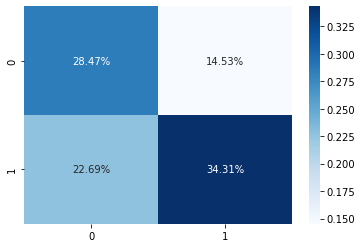

In [106]:

cf_matrix = confusion_matrix(y_data_MCI, ypred_model2)
print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()


In [86]:
model2 = create_model_2D_epsilon(X_train[0].shape)
model2.summary()
model2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train, Y_train, epochs=15)
ypred_model = model2.predict(X_data_MCI)
ypred_model = np.where(ypred_model > 0.5, 1, 0)
ypred_model = np.argmax(ypred_model, axis= 1)

acc_model = accuracy_score(ypred_model, y_data_MCI)

print('accuracy on MCI data based on CN and AD training: {} '.format(acc_model))

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_18 (S  (None, 40, 40, 3)   0           ['input_7[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_19 (S  (None, 40, 40, 3)   0           ['input_7[0][0]']                
 licingOpLambda)                                                                            